In [1]:

import tensorflow as tf
import keras
import pickle
import matplotlib.pyplot as plt
import numpy as np
from data.utils import restore_pinn_model, plot_test
from data.utils import plot_states_BCS, plot_u
from data.parameters import Parameters
# from data.TrainingReport import TrainingReport
from data.PinnPredictor import PinnPredictor
with open("dataset_opera.pk", 'rb') as open_file:
    ds = pickle.load(open_file)
predictor=PinnPredictor("data_model02")
BCS_parameters=Parameters()

Loading model from data_model02


<Figure size 1440x288 with 0 Axes>

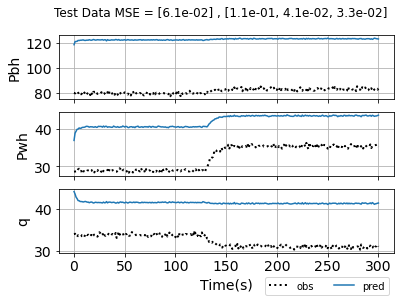

In [2]:
def free_predict(tstart,nsim,ds,model):
    X=ds.train_X[tstart:tstart+1,:,:]
    y=ds.train_y_full[tstart:tstart+nsim+1,:,:]
    u=ds.train_X[tstart:tstart+nsim+1,:,:]
    U=ds.train_X[tstart:tstart+nsim+1,:,:4]
    Xx=X[:,:,-2:]
    X0=X
    y0=model(X0)[:,0:1,:]
    pred=y0
    for i in range(nsim):
        Xx=tf.concat([Xx[:,1:,:],y0[:,:,:-1]],1) # Remove o instante mais antigo e atualiza o vetor de estados com a nova predição (remove q) 
        #print(U[i:i+1,:,:].shape)
        X0=tf.concat([U[i:i+1,:,:],Xx],2) # Remonta o vetor de entrada da rede (exógenas+saidas)
        y0=model(X0)[:,0:1,:]
        pred=tf.concat([pred,y0[:,0:1,:]],0)
    return pred,y,u
    
tstart=0
nsim=300


pred, yreal, ureal=free_predict(tstart,nsim,ds,predictor.model)
#np.square(yreal[:,0,2]- pred[:,0,2])
FigFree=plot_test(yreal, pred,[ds.parameters.xc,ds.parameters.x0])

plt.show()  # Uncomment to see the graphics



In [3]:
#Initial conditions
xi=np.array([7.92750470e+06, 2.90972936e+06], ndmin=2) #bar
ui=np.array([4.95914975e+01, 5.00190605e+01, 1.99149787e+06, 1.18634314e+07],ndmin=2) #Hz, 0-100%, bar,bar
#----------------------------------------------------------------
# Normalizar
xi=BCS_parameters.normalizar_x(xi)
xi=[xi[0,0],xi[0,1]]
print(xi)
ui=BCS_parameters.normalizar_u(ui)
print(ui)
Xi=tf.convert_to_tensor(np.array([[xi]*20]), dtype=tf.float32)# Replicate to build NN input
Ui=tf.convert_to_tensor(np.array([[ui]*20]), dtype=tf.float32) # Replicate to build NN input

[0.626200376, 0.5734141551020407]
[ 0.82652496  0.50019061  0.87944208 -0.0682843 ]


In [4]:
ds.u[0:20,:]

array([[0.84086367, 0.50016219, 2.21992621, 5.93190182],
       [0.83533493, 0.50065122, 2.21653081, 6.04113816],
       [0.82980054, 0.50096988, 2.19969134, 5.97266778],
       [0.83243496, 0.50017267, 2.24469877, 6.03187481],
       [0.84144758, 0.49913309, 2.23154185, 5.96601468],
       [0.82944945, 0.50056413, 2.20310625, 6.08777158],
       [0.83635201, 0.49994856, 2.24418763, 6.03230039],
       [0.83689972, 0.49976562, 2.2077236 , 5.90948337],
       [0.84135141, 0.49995875, 2.22845186, 6.02025005],
       [0.8314947 , 0.4999655 , 2.20030699, 6.02659458],
       [0.83485211, 0.50024497, 2.24218424, 6.02182734],
       [0.83739134, 0.49942839, 2.20398915, 5.9196172 ],
       [0.83809515, 0.50096464, 2.16581261, 5.9996212 ],
       [0.83204514, 0.50030224, 2.19733978, 6.10008821],
       [0.83009991, 0.49941931, 2.24592142, 6.09172196],
       [0.83434344, 0.49991032, 2.19234081, 5.98681673],
       [0.83459309, 0.49999162, 2.24121965, 6.00411445],
       [0.83641051, 0.49904099,

In [5]:
ds.train_X[0,:,:4]

<tf.Tensor: shape=(20, 4), dtype=float32, numpy=
array([[0.83243495, 0.5001727 , 2.2446988 , 6.0318747 ],
       [0.8414476 , 0.49913308, 2.2315419 , 5.966015  ],
       [0.8294495 , 0.50056416, 2.2031062 , 6.0877714 ],
       [0.836352  , 0.49994856, 2.2441876 , 6.0323005 ],
       [0.8368997 , 0.4997656 , 2.2077236 , 5.9094834 ],
       [0.8413514 , 0.49995875, 2.228452  , 6.02025   ],
       [0.8314947 , 0.4999655 , 2.200307  , 6.0265946 ],
       [0.8348521 , 0.500245  , 2.2421842 , 6.021827  ],
       [0.8373913 , 0.4994284 , 2.203989  , 5.919617  ],
       [0.8380951 , 0.50096464, 2.1658125 , 5.9996214 ],
       [0.83204514, 0.50030226, 2.1973398 , 6.100088  ],
       [0.8300999 , 0.4994193 , 2.2459214 , 6.091722  ],
       [0.83434343, 0.49991032, 2.1923409 , 5.986817  ],
       [0.83459306, 0.49999163, 2.2412198 , 6.0041146 ],
       [0.8364105 , 0.499041  , 2.1972425 , 6.014476  ],
       [0.8383486 , 0.49975005, 2.2041872 , 6.0465508 ],
       [0.83319706, 0.50017595, 2.20226

In [18]:
def normalizar_u(u):
    aux=[]
    u[2]=u[2]-BCS_parameters.u0[0] 
    u[3]=u[3]-BCS_parameters.u0[1]
    for i,valor in enumerate(u):
        aux.append(valor/BCS_parameters.uc[i])
    return np.hstack(aux)


In [22]:
ds.u.shape

(3000, 4)

In [19]:
un=normalizar_u(ds.u)

IndexError: list index out of range

In [7]:
nsim=800
y0=predictor.model(tf.concat([Ui,Xi],2))
pred=y0
pred

<tf.Tensor: shape=(1, 1, 3), dtype=float32, numpy=array([[[0.62749344, 0.56702405, 0.35376877]]], dtype=float32)>

In [8]:

nsim=300
y0=predictor.model(tf.concat([Xi,Ui],2))
predict=y0
nsteps=ds.n_steps_in
for i in range(nsim):
        Xi=tf.concat([Xi[:,1:,:],y0[:,:,:-1]],1) # Remove older time-step and update states vector with new predictions (remove q)
        Ui=tf.concat([Ui[:,1:,:],np.array([ds.un[nsteps+i:nsteps+i+1,:]])],1) # Remove older time-step and update exogenous vector with the next time-step
        y0=predictor.model(tf.concat([Ui,Xi],2)) # Compute the next prediction
        predict=tf.concat([predict,y0],0) # Store 
        
predict=predict.numpy()

ti=0;to=ti+nsim+1;


In [9]:
y=ds.train_y_full[ti:to,:,:]
u=ds.train_X[ti:to,0,:4]
t=np.arange(0,nsim+1,1)

# plot_states_BCS(predict[:,0,:],t,norm=1)
# plot_test(y, predict,[BCS_parameters.xc,BCS_parameters.x0])


In [10]:
predictor.model(ds.train_X[0:10,:,:])[:,0,:]

<tf.Tensor: shape=(10, 3), dtype=float32, numpy=
array([[0.93918043, 0.734161  , 0.57997227],
       [0.93896914, 0.73206925, 0.581013  ],
       [0.9377304 , 0.7347419 , 0.5820043 ],
       [0.9428275 , 0.73250335, 0.5779089 ],
       [0.9397854 , 0.73365426, 0.579474  ],
       [0.9412684 , 0.7317899 , 0.577257  ],
       [0.94062   , 0.73263234, 0.5771128 ],
       [0.9418828 , 0.7350149 , 0.57792944],
       [0.9413931 , 0.7327133 , 0.57773274],
       [0.938863  , 0.73377335, 0.5789876 ]], dtype=float32)>

In [11]:
ds.train_y_full[0:10,0,:]

<tf.Tensor: shape=(10, 3), dtype=float32, numpy=
array([[0.6317127 , 0.56306523, 0.37996078],
       [0.62798303, 0.5639878 , 0.38166392],
       [0.6358896 , 0.56474197, 0.3704097 ],
       [0.62515116, 0.56148547, 0.36622456],
       [0.63059247, 0.5761086 , 0.37480712],
       [0.6333523 , 0.5792887 , 0.37013865],
       [0.6371243 , 0.56407803, 0.36689553],
       [0.62221086, 0.5644605 , 0.3697738 ],
       [0.6295962 , 0.5773473 , 0.37588248],
       [0.6432503 , 0.5641995 , 0.37492627]], dtype=float32)>

In [12]:
predict[0:10,0,:]


array([[0.7428766 , 0.30886072, 0.2558667 ],
       [0.882627  , 0.6045433 , 0.42639345],
       [0.9217171 , 0.6644821 , 0.48334605],
       [0.9448597 , 0.7024982 , 0.5025459 ],
       [0.95272547, 0.73101604, 0.5125175 ],
       [0.9592392 , 0.74566984, 0.51745176],
       [0.96209544, 0.7587235 , 0.5218203 ],
       [0.9649712 , 0.7723733 , 0.523435  ],
       [0.96731454, 0.78023195, 0.5232952 ],
       [0.96562016, 0.7860515 , 0.52587014]], dtype=float32)

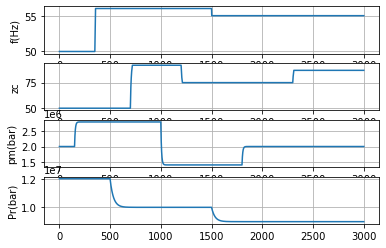

In [13]:
#Valores iniciais de simulação
tss=5 # Tempo inicial no estacionário
ts=1
pi=3.14159
npv=3
nmv=2
nde=2
tsim = 50*60; 
nsim=int(round(tsim/ts)+1)
#xss_n=xssn

Yk = np.zeros((npv,1))
Uk = np.zeros((nmv+nde,1))
Ymk = Yk
Ys = Yk
Ymin = Yk
Ymax = Yk

# fill vector x 
def lpf(x, omega_c, T):
    """Implement a first-order low-pass filter. 
    The input data is x, the filter's cutoff frequency is omega_c 
    [rad/s] and the sample time is T [s].  The output is y.
    """
    N=x.shape[0]
    y = x
    alpha = (2-T*omega_c)/(2+T*omega_c)
    beta = T*omega_c/(2+T*omega_c)
    for k in range(1, N):
        y[k] = alpha*y[k-1] + beta*(x[k]+x[k-1])
    return y

def step_function(tsim):
    x=np.arange(0,tsim)
    val_pm=[20e5,28e5,14e5,20e5]
    val_z=[50,100,75,95]
    val_f=[50,63,55,60]
    val_pr=[1.2e7,1e7,0.9e7]
    list_f=[(x >= 0) & (x<350), (x >= 350) & (x < 1500),(x >= 1500) & (x < 2600), x>=2600]
    list_z=[(x >= 0) & (x<700), (x >= 700) & (x < 1200), (x >= 1200) & (x < 2300),x>=2300]
    list_pm=[(x >= 0) & (x<150),  (x >=150) & (x<1000),(x >= 1000) & (x < 1800), x>=1800]
    list_pr=[(x >= 0) & (x<500),  (x >= 500) & (x < 1500), x>=1500]
    pm=np.piecewise(x,list_pm,val_pm)
    fk=np.piecewise(x,list_f, val_f)
    zc=np.piecewise(x,list_z, val_z)
    pr_z=np.piecewise(x,list_pr, val_pr)

    # Wn=2*pi*1/25
    # Wn2=2*pi*1/100    
    Wn=2*pi*0.05
    Wn2=2*pi*0.01
    pm_f=lpf(pm,Wn,1)
    pr_f=lpf(pr_z,Wn2,1)
    return np.array([lpf(fk,Wn,1),lpf(zc,Wn2*4,1),pm_f,pr_f])

label = ['f(Hz)',"zc", "pm(bar)", "Pr(bar)"];
f,zc,pm,pr=step_function(tsim)
entradas=[f,zc,pm,pr]
fig2=plt.figure()
for i,str in enumerate(label):
    ax=fig2.add_subplot(len(label),1,i+1)
    ax.plot(entradas[i].T, label='Medição')
    ax.set_ylabel(str)
    plt.grid(True)


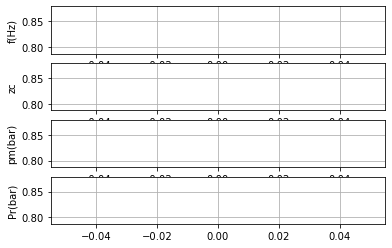

In [14]:
norm_inputs=[]
norm_inputs=predictor.norm_u(entradas)
fig2=plt.figure()    
entradas=norm_inputs
for i,str in enumerate(label):
    ax=fig2.add_subplot(len(label),1,i+1)
    ax.plot(entradas[i].T, label='Medição')
    ax.set_ylabel(str)
    plt.grid(True)

(3000, 3)


(3000,)

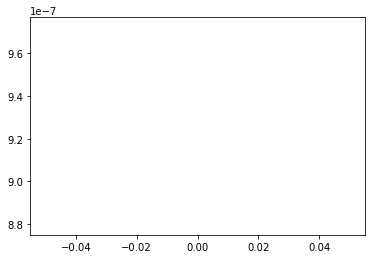

In [15]:
plt.plot((entradas[2]-ds.parameters.u0[0])/ds.parameters.uc[2])
print(ds.x.shape)
f.shape

In [16]:
predictor.norm_u(entradas)


IndexError: list index out of range

In [ ]:
#Initial conditions
xi=[10466565.75 ,  2546688.433] #bar
ui=[5.32846998e+01, 1.96547200e+00, 1.75045886e+06, 1.31403633e+07] #Hz, 0-100%, bar,bar
X0=xi+ui # join u with x
X0=np.array([[X0]*20]) # Replicate to build NN input
X0=tf.convert_to_tensor(X0, dtype=tf.float32) # convert_to_tensor



    

predictor.model.predict(X0) # model output